
<div align="center">

<img src='https://www.globalcitizensolutions.com/wp-content/uploads/2022/12/InternationalSharingSchoolMadeira.png' align="center">

<h1 > Julio Manuel Gouveia Dominguez, Machine learning Global Warming Prediction</h1>

<img src='https://www.geek4maniacs.pt/climate/julio.png' align="center">


</div>







In [ ]:
#Load Libraries
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt



In [ ]:
# read temperature data
try:
    with open('temp.txt', 'r') as file:
        temp_data = file.readlines()
except:
    !wget https://www.geek4maniacs.pt/temp.txt
    with open('temp.txt', 'r') as file:
        temp_data = file.readlines()

temp_data = temp_data[83:]

years = []
min_temp = []
max_temp = []

for line in temp_data:
    line = line.strip().split()
    years.append(int(line[0]))
    min_temp.append(float(line[2]))
    max_temp.append(float(line[1]))

# read CO2 data
try:
    with open('co2.txt', 'r') as file:
        co2_data = file.readlines()
except:
    !wget https://www.geek4maniacs.pt/co2.txt
    with open('co2.txt', 'r') as file:
        co2_data = file.readlines()

co2_data = co2_data[58:-3:12]

co2_years = []
co2_levels = []

for line in co2_data:
    line = line.strip().split()
    co2_years.append(int(line[0]))
    co2_levels.append(float(line[4]))


df=pd.DataFrame()
df['years']=years
df['min_temp']=min_temp
df['max_temp']=max_temp
df['Average Temp']=(df['min_temp']+df['max_temp'])/2
df['co2_levels']=co2_levels


print(df.tail(60))

    years  min_temp  max_temp  Average Temp  co2_levels
5    1963     -0.03      0.05         0.010      318.57
6    1964     -0.04     -0.20        -0.120      319.41
7    1965     -0.05     -0.11        -0.080      319.59
8    1966     -0.06     -0.06        -0.060      321.08
9    1967     -0.05     -0.02        -0.035      321.73
10   1968     -0.03     -0.08        -0.055      322.55
11   1969     -0.02      0.05         0.015      324.31
12   1970     -0.00      0.03         0.015      325.61
13   1971      0.00     -0.08        -0.040      325.85
14   1972      0.00      0.01         0.005      326.39
15   1973     -0.00      0.16         0.080      328.96
16   1974      0.01     -0.07        -0.030      330.14
17   1975      0.02     -0.01         0.005      330.37
18   1976      0.04     -0.10        -0.030      331.78
19   1977      0.07      0.18         0.125      333.40
20   1978      0.12      0.07         0.095      335.00
21   1979      0.16      0.16         0.160     

In [ ]:
# prepare data
X = np.column_stack((max_temp, min_temp, co2_levels))
y = np.array(years)

# normalize the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = (y - np.mean(y)) / np.std(y)

# convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)

# create a linear regression model
model = nn.Linear(3, 1)

# define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# train the model
num_epochs = 5000
batch_size = 16

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

for epoch in tqdm(range(num_epochs)):
    for batch_X, batch_y in (dataloader):
        optimizer.zero_grad()
        output = model(batch_X)
        loss = loss_fn(output, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        



100%|██████████| 5000/5000 [00:09<00:00, 523.14it/s]


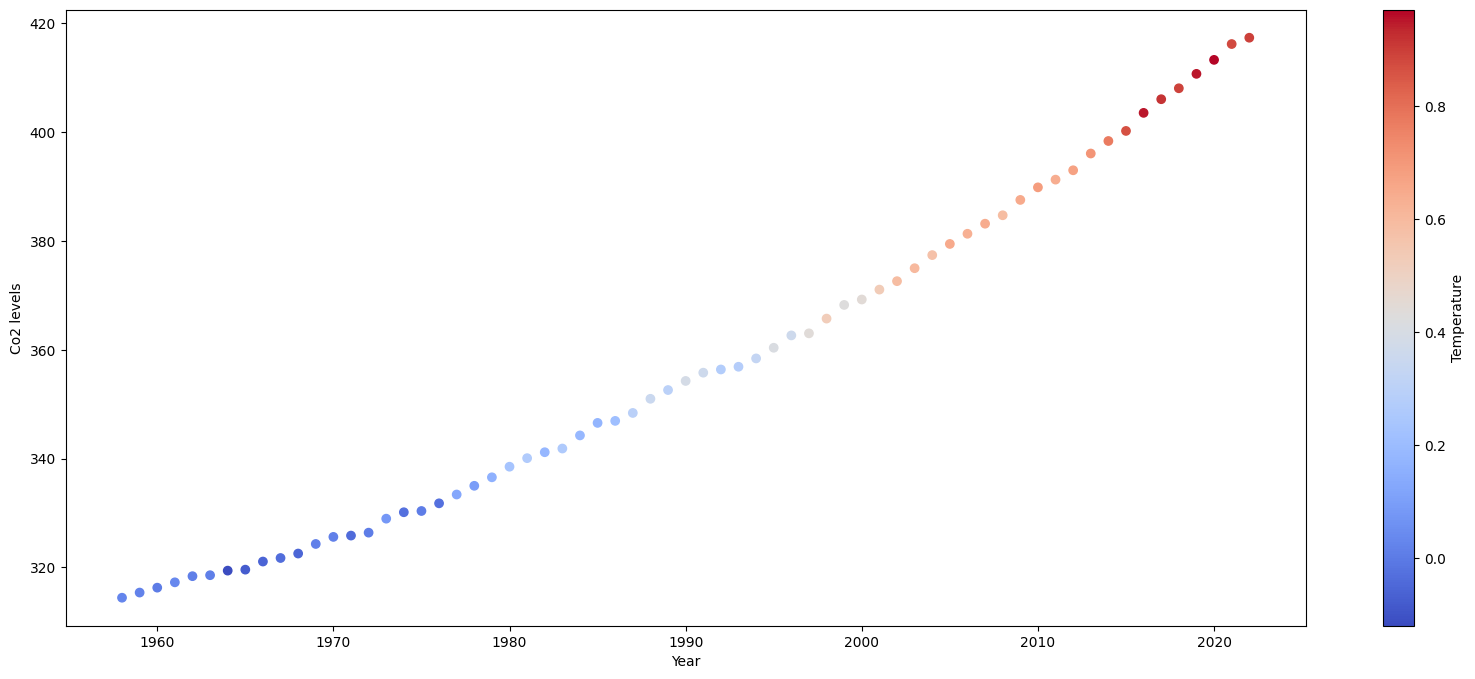

In [ ]:

# convert the predictions to years and denormalize
predicted_years = model(X_tensor).detach().numpy() * np.std(years) + np.mean(years)

# Create a new figure and set the size
fig = plt.figure(figsize=(20, 8))

# plot the data
min_temp_arr = np.array(min_temp)
max_temp_arr = np.array(max_temp)
avg_temp = (min_temp_arr + max_temp_arr) / 2
co2_levels_arr = np.array(co2_levels)
plt.scatter(years, co2_levels_arr, c=avg_temp, cmap='coolwarm')
plt.colorbar(label='Temperature')
plt.xlabel('Year')
plt.ylabel('Co2 levels')
plt.show()


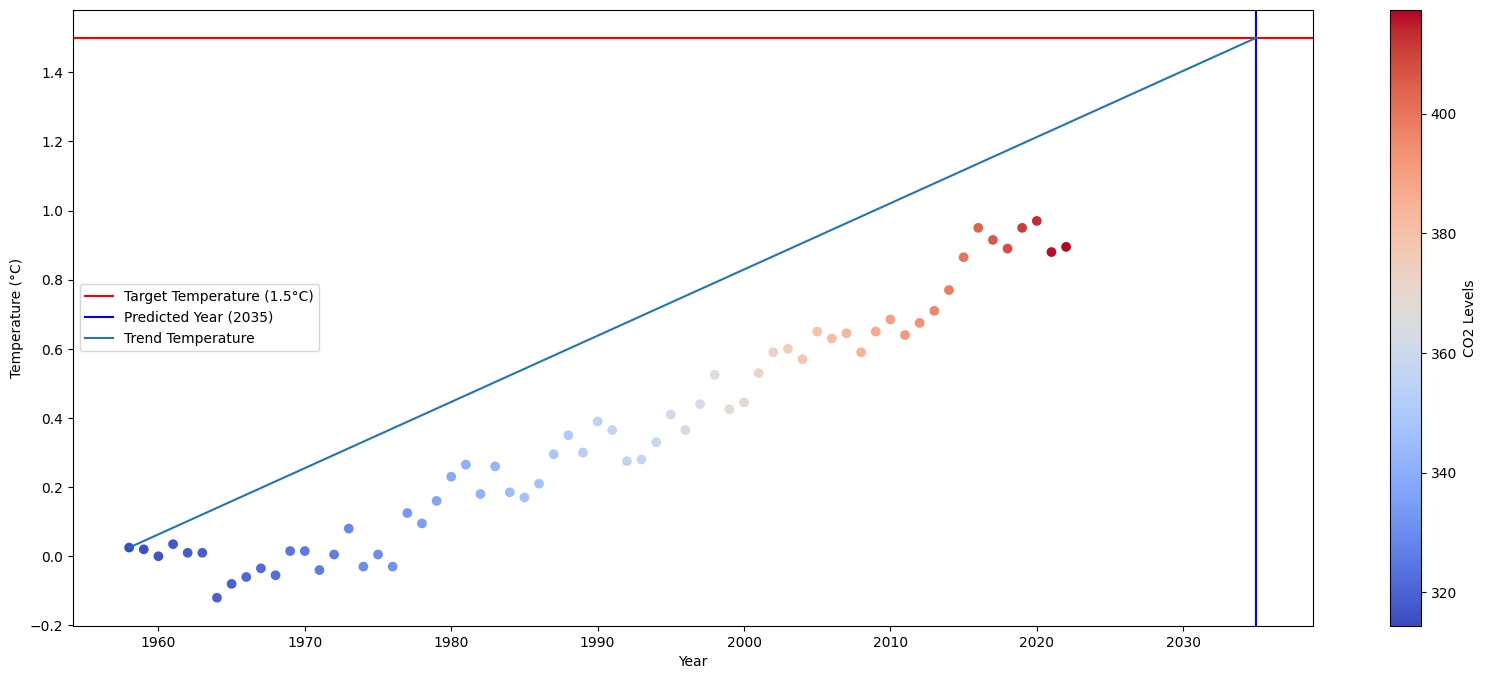

In [ ]:
# convert the predictions to years and denormalize
predicted_years = model(X_tensor).detach().numpy() * np.std(years) + np.mean(years)

# Create a new figure and set the size
fig = plt.figure(figsize=(20, 8))

# plot the data
min_temp_arr = np.array(min_temp)
max_temp_arr = np.array(max_temp)
avg_temp = (min_temp_arr + max_temp_arr) / 2
co2_levels_arr = np.array(co2_levels)
plt.scatter(years, avg_temp, c=co2_levels_arr, cmap='coolwarm')
plt.colorbar(label='CO2 Levels')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')



# plot the target temperature
target_temp = 1.5
normalized_target_temp = (target_temp - np.mean(min_temp + max_temp) ) / np.std(min_temp + max_temp) 
normalized_co2 = (co2_levels[-1] - np.mean(co2_levels)) / np.std(co2_levels)
input_tensor = torch.tensor([normalized_target_temp, normalized_target_temp, normalized_co2], dtype=torch.float).view(1, -1)
predicted_year = int(model(input_tensor).detach().numpy()[0, 0] * np.std(years) + np.mean(years))
plt.axhline(y=target_temp, color='red', label=f'Target Temperature ({target_temp}°C)')
plt.axvline(x=predicted_year, color='blue', label=f'Predicted Year ({predicted_year})')



# Define the start and end points of the line
x_start, y_start = years[0], avg_temp[0]
x_end, y_end = predicted_year, target_temp

# Plot the line using the plot() function
plt.plot([x_start, x_end], [y_start, y_end], label="Trend Temperature")




plt.legend()
plt.show()

